#### In this notebook, we will explore the usage of MultiNodeWeightedSampler in torchdata.nodes


##### MultiNodeWeightedSampler allows us to sampler with a probability from multiple datsets
##### We will create three sample datasets, and see how changing the sampling probability affects the final model predicts

In [1]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import default_collate 
import torch.nn.init as init
import matplotlib.pyplot as plt

from torchdata.nodes.adapters import IterableWrapper
from torchdata.nodes.batch import Batcher
from torchdata.nodes.map import Mapper
from torchdata.nodes.loader import Loader
from torchdata.nodes.samplers.multi_node_weighted_sampler import MultiNodeWeightedSampler

##### First we create three datasets: Gaussian, Uniform, and LogNormal distributions in the range x [-1,1]

In [2]:
# We create a dataset and store in a csv file to mimic loading data from local csv files
x = np.arange(-1, 1, 0.001)
def gaussian(x):
    return np.exp(-x**2)
y = gaussian(x)
df = pd.DataFrame({'x': x, 'y': y})
# Save the DataFrame to a CSV file
df.to_csv('data/gaussian_dataset.csv', index=False)

In [3]:

def uniform(x):
    return np.random.uniform(0, 1, size=len(x))
y = uniform(x)
df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('data/uniform_dataset.csv', index=False)

In [4]:

def lognormal(x, mean=0, sigma=1):
    return np.exp(mean + sigma * x)
y = lognormal(x)
df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('data/lognormal_dataset.csv', index=False)

##### Let's load the dataset CSVs

In [5]:
gaussian_df = pd.read_csv('data/gaussian_dataset.csv',)
gaussian_df = gaussian_df.values
np.random.shuffle(gaussian_df)
uniform_df = pd.read_csv('data/uniform_dataset.csv',)
uniform_df = uniform_df.values
np.random.shuffle(uniform_df)
lognormal_df = pd.read_csv('data/lognormal_dataset.csv',)
lognormal_df = lognormal_df.values
np.random.shuffle(lognormal_df)

In [6]:
train_fraction = 0.8
num_train_samples = int(train_fraction*len(gaussian_df))

train_dataset_gaussian = gaussian_df[:num_train_samples]
test_dataset_gaussian = gaussian_df[num_train_samples:]


train_dataset_uniform = uniform_df[:num_train_samples]
test_dataset_uniform = uniform_df[num_train_samples:]


train_dataset_lognormal = lognormal_df[:num_train_samples]
test_dataset_lognormal= lognormal_df[num_train_samples:]



In [7]:
#We need a mapper function to convert a dtype 
def map_fn(item):
    return {"x":torch.tensor(item[0], dtype= torch.float32).unsqueeze(0), "y":torch.tensor(item[1], dtype= torch.float32).unsqueeze(0)}

gaussian_node = Mapper(IterableWrapper(train_dataset_gaussian), map_fn)
uniform_node = Mapper(IterableWrapper(train_dataset_uniform), map_fn)
lognormal_node = Mapper(IterableWrapper(train_dataset_lognormal), map_fn)

datasets = {"gaussian":gaussian_node, "uniform": uniform_node , "lognormal": lognormal_node}






##### Let's see how the prediction changes if we change the weightage of the Gaussian dataset


In [8]:
gaussian_weights = [0.1*i+0.5 for i in range(5)]



In [9]:
weights_list = []

for weight in gaussian_weights:
    remaining  = 1-weight
    weights_list.append({"gaussian":weight, "uniform": remaining/2, "lognormal": remaining/2})

In [10]:
weights_list

[{'gaussian': 0.5, 'uniform': 0.25, 'lognormal': 0.25},
 {'gaussian': 0.6, 'uniform': 0.2, 'lognormal': 0.2},
 {'gaussian': 0.7,
  'uniform': 0.15000000000000002,
  'lognormal': 0.15000000000000002},
 {'gaussian': 0.8,
  'uniform': 0.09999999999999998,
  'lognormal': 0.09999999999999998},
 {'gaussian': 0.9,
  'uniform': 0.04999999999999999,
  'lognormal': 0.04999999999999999}]

In [11]:

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 128)  # input layer (1) -> hidden layer (128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        
        self.fc3 = nn.Linear(128, 1)  # hidden layer (128) -> output layer (1)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [12]:
def train_model(weights, batch_size = 512):
    

    model = Net()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    node = MultiNodeWeightedSampler(datasets, weights)
    train_batcher = Loader(Batcher(node, batch_size, drop_last=True))
    # Train the model
    for epoch in range(100):
        for batch in train_batcher:
            batch = default_collate(batch)
            x = batch["x"]
            y = batch["y"]
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        #print(f'Epoch {epoch+1}, Loss: {loss.item()/1000}')
    return model


In [13]:
output_models = {}

for weights in weights_list :
    print(f"Training for Gaussian weight = {weights["gaussian"]}")
    output_models[weights["gaussian"]] = train_model(weights)




Training for Gaussian weight = 0.5
Training for Gaussian weight = 0.6
Training for Gaussian weight = 0.7
Training for Gaussian weight = 0.8
Training for Gaussian weight = 0.9



##### Our models are trained at varies weight fractions for the Gaussian model, let's check out how the outputs look like for each model

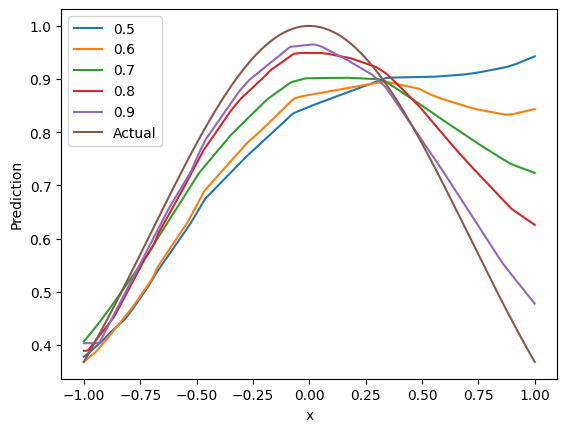

In [14]:
x =  np.linspace(-1,1, 200)
plt.plot()
for weights in weights_list :

    model = output_models[weights["gaussian"]]
    # Generate some data

    y = gaussian(x)
    # Convert data to tensors
    x_tensor = torch.from_numpy(x).float().unsqueeze(-1)
    y_tensor = torch.from_numpy(y).float().unsqueeze(-1)
    
    predicted = model(x_tensor).detach().numpy()
    
    plt.plot(x, predicted, label=weights["gaussian"])
    

plt.plot(x, y, label='Actual')
plt.xlabel("x")
plt.ylabel("Prediction")
plt.legend()
    

##### As expected, as the weightage of the Gaussian model is increased, the outputs follow a Gaussian distribution